In [1]:
import networkx as nx
import preprocessing as prep
import numpy as np
import pandas as pd
import numpy as np
import json
import os
import datetime
import pytz
import matplotlib.pyplot as plt
from collections import Counter
from bb_binary import load_frame_container, Repository
from pandas import Series, DataFrame
import seaborn as sns
import igraph as ig
import sqlite3

In [24]:
%matplotlib inline

In [188]:
g1 = ig.Graph.Read_GraphML('networks/0820_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-20_08:00:00+00:00.graphml')

In [189]:
rg = ig.Graph.Erdos_Renyi(n=len(g1.vs), m=len(g1.es))

In [190]:
def getValuesRandom(vertices, edges):
    deg = []
    lcc = []
    close = []
    between = []
    for i in list(range(100)):
        rg = ig.Graph.Erdos_Renyi(n=vertices, m=edges)
        deg.append(rg.degree())
        lcc.append(rg.transitivity_local_undirected())
        close.append(rg.closeness())
        between.append(rg.betweenness())
        print('.',sep='')
    return deg,lcc,close,between

In [191]:
deg_rand, lcc_rand, close_rand, between_rand = getValuesRandom(len(g1.vs), len(g1.es))

.
.


KeyboardInterrupt: 

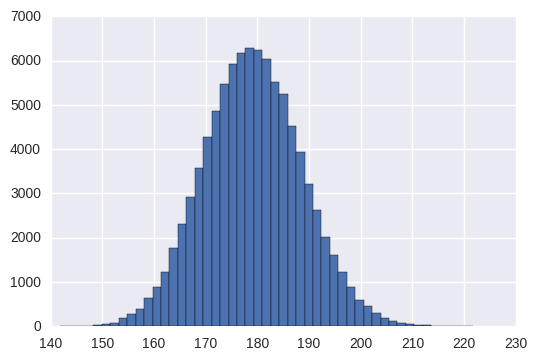

In [187]:
pd.concat([Series(i) for i in between_rand]).hist(bins=50)

In [192]:
def calcRandom(g,n=100):
    values = []
    for i in list(range(100)):
        rg = ig.Graph.Erdos_Renyi(n=len(g.vs), m=len(g.es))
        v = rg.transitivity_undirected()
        density = rg.density()
        diameter = rg.diameter()
        avpath = rg.average_path_length()
        avdeg = Series(rg.degree()).mean()
        values.append({'cc': v, 'density': density, 'diameter': diameter, 'avpath': avpath, 'avdeg': avdeg})
    return values

In [193]:
list1 = calcRandom(g1,100)

In [131]:
DataFrame(list1).describe()

,avdeg,avpath,cc,density,diameter
count,1.000000e+02,100.000000,100.000000,100.000000,100.0
mean,6.316247e+02,1.314197,0.685796,0.685803,2.0
std,1.142596e-13,0.000000,0.000041,0.000000,0.0
min,6.316247e+02,1.314197,0.685695,0.685803,2.0
25%,6.316247e+02,1.314197,0.685770,0.685803,2.0
50%,6.316247e+02,1.314197,0.685794,0.685803,2.0
75%,6.316247e+02,1.314197,0.685820,0.685803,2.0
max,6.316247e+02,1.314197,0.685910,0.685803,2.0


In [132]:
g2 = ig.Graph.Read_GraphML('networks/0822_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-22_08:00:00+00:00.graphml')

In [133]:
list2 = calcRandom(g2,100)

In [135]:
DataFrame(list2).describe()

,avdeg,avpath,cc,density,diameter
count,100.000000,1.000000e+02,100.000000,1.000000e+02,100.0
mean,523.652352,1.464020e+00,0.535973,5.359799e-01,2.0
std,0.000000,2.231632e-16,0.000055,1.115816e-16,0.0
min,523.652352,1.464020e+00,0.535850,5.359799e-01,2.0
25%,523.652352,1.464020e+00,0.535938,5.359799e-01,2.0
50%,523.652352,1.464020e+00,0.535965,5.359799e-01,2.0
75%,523.652352,1.464020e+00,0.536014,5.359799e-01,2.0
max,523.652352,1.464020e+00,0.536135,5.359799e-01,2.0


In [136]:
g3 = ig.Graph.Read_GraphML('networks/0824_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-24_08:00:00+00:00.graphml')

In [137]:
list3 = calcRandom(g3,100)

In [138]:
DataFrame(list3).describe()

,avdeg,avpath,cc,density,diameter
count,100.000000,1.000000e+02,100.000000,1.000000e+02,100.0
mean,562.735358,1.388995e+00,0.611006,6.110047e-01,2.0
std,0.000000,4.463264e-16,0.000049,1.115816e-16,0.0
min,562.735358,1.388995e+00,0.610880,6.110047e-01,2.0
25%,562.735358,1.388995e+00,0.610972,6.110047e-01,2.0
50%,562.735358,1.388995e+00,0.611008,6.110047e-01,2.0
75%,562.735358,1.388995e+00,0.611043,6.110047e-01,2.0
max,562.735358,1.388995e+00,0.611123,6.110047e-01,2.0


In [34]:
def thresholdedGraph(file, border):

    G = nx.read_graphml(file)
    print(nx.info(G))
    
    lowedges = []
    for a,b in list(G.edges()):
        data = G.get_edge_data(a,b)
        f = data.get('frequency')
        if f <= border:
            lowedges.append((a,b))

    print("anzahl removed edges", len(lowedges))
    for e in lowedges:
        G.remove_edge(e[0],e[1])

    print(nx.info(G))

    Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    print("Number of components: {}".format(len(Gcc)))

    size_components = []
    for comp in Gcc:
        size_components.append(nx.number_of_nodes(comp))
    
    print(Counter(list(size_components)))

    G = Gcc[0]

    nx.write_graphml(G, 'ttt.graphml')
    
    return ig.Graph.Read_GraphML('ttt.graphml')

In [80]:
def thresholdedGraph2(G, border):
    lowedges = []
    for a,b in list(G.edges()):
        data = G.get_edge_data(a,b)
        f = data.get('frequency')
        if f <= border:
            lowedges.append((a,b))
    print("anzahl removed edges", len(lowedges))
    for e in lowedges:
        G.remove_edge(e[0],e[1])
    print(nx.info(G))
    Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    print("Number of components: {}".format(len(Gcc)))
    size_components = []
    for comp in Gcc:
        size_components.append(nx.number_of_nodes(comp))
    print(Counter(list(size_components)))
    G = Gcc[0]    
    return G

In [63]:
gtest = thresholdedGraph('networks/0824_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-24_08:00:00+00:00.graphml', 120)

Name: 
Type: Graph
Number of nodes: 922
Number of edges: 259421
Average degree: 562.7354
anzahl removed edges 259358
Name: 
Type: Graph
Number of nodes: 922
Number of edges: 63
Average degree:   0.1367
Number of components: 859
Counter({1: 827, 2: 17, 3: 6, 4: 5, 6: 3, 5: 1})


In [64]:
gtest.summary()

'IGRAPH U--- 6 5 -- \n+ attr: id (v), finv (e), frequency (e), totalduration (e)'

In [66]:
list(gtest.vs)

[igraph.Vertex(<igraph.Graph object at 0x7f51df87fd68>, 0, {'id': '3080'}),
 igraph.Vertex(<igraph.Graph object at 0x7f51df87fd68>, 1, {'id': '3851'}),
 igraph.Vertex(<igraph.Graph object at 0x7f51df87fd68>, 2, {'id': '626'}),
 igraph.Vertex(<igraph.Graph object at 0x7f51df87fd68>, 3, {'id': '524'}),
 igraph.Vertex(<igraph.Graph object at 0x7f51df87fd68>, 4, {'id': '644'}),
 igraph.Vertex(<igraph.Graph object at 0x7f51df87fd68>, 5, {'id': '32'})]

In [72]:
gtest.get_eid(4,0)

0

In [65]:
list(gtest.es)

[igraph.Edge(<igraph.Graph object at 0x7f51df87fd68>, 0, {'frequency': 185.0, 'finv': 0.005405405405405406, 'totalduration': 2266.0}),
 igraph.Edge(<igraph.Graph object at 0x7f51df87fd68>, 1, {'frequency': 134.0, 'finv': 0.007462686567164179, 'totalduration': 1957.0}),
 igraph.Edge(<igraph.Graph object at 0x7f51df87fd68>, 2, {'frequency': 211.0, 'finv': 0.004739336492890996, 'totalduration': 3625.0}),
 igraph.Edge(<igraph.Graph object at 0x7f51df87fd68>, 3, {'frequency': 132.0, 'finv': 0.007575757575757576, 'totalduration': 1804.0}),
 igraph.Edge(<igraph.Graph object at 0x7f51df87fd68>, 4, {'frequency': 126.0, 'finv': 0.007936507936507936, 'totalduration': 2607.0})]

In [79]:
gtest.closeness(weights='finv', normalized=True)

[56.799133199602686,
 62.20017868007172,
 98.9415727236403,
 61.85217179293729,
 75.29225731756699,
 98.9415727236403]

In [60]:
list(gtest.vs)

[igraph.Vertex(<igraph.Graph object at 0x7f51df87fb88>, 0, {'id': '1404'}),
 igraph.Vertex(<igraph.Graph object at 0x7f51df87fb88>, 1, {'id': '3731'}),
 igraph.Vertex(<igraph.Graph object at 0x7f51df87fb88>, 2, {'id': '2780'}),
 igraph.Vertex(<igraph.Graph object at 0x7f51df87fb88>, 3, {'id': '1092'})]

In [84]:
gg = nx.read_graphml('networks/0824_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-24_08:00:00+00:00.graphml')

In [85]:
gg = thresholdedGraph2(gg, 120)

anzahl removed edges 259358
Name: 
Type: Graph
Number of nodes: 922
Number of edges: 63
Average degree:   0.1367
Number of components: 859
Counter({1: 827, 2: 17, 3: 6, 4: 5, 6: 3, 5: 1})


In [86]:
nx.info(gg)

'Name: \nType: Graph\nNumber of nodes: 6\nNumber of edges: 5\nAverage degree:   1.6667'

In [102]:
nx.closeness_centrality(gg, distance='finv')

{'3080': 56.799133199602686,
 '32': 98.9415727236403,
 '3851': 62.200178680071716,
 '524': 61.85217179293728,
 '626': 98.9415727236403,
 '644': 75.29225731756699}

In [100]:
gg.edges()

[('3080', '644'),
 ('3851', '626'),
 ('626', '32'),
 ('626', '524'),
 ('644', '32')]